In [1]:
from agents import DPM_Agent, agent_loss, sampled_agent_reward
from trading_env.environment import TradingEnv

In [2]:
import dill
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
yf_file = "./data/archive_data/yf_data.dill"
with open(yf_file,'rb') as dill_file:
    yf_df = dill.load(dill_file)
    

In [4]:
print('Head of data set:')
yf_df.head()

Head of data set:


,Date,Symbol,high,low,open,close,volume,adjclose
0,2011-01-03,MMM,87.330002,86.739998,86.750000,86.790001,2632800,65.234962
1,2011-01-04,MMM,87.279999,86.279999,87.000000,86.669998,2644100,65.144775
2,2011-01-05,MMM,87.900002,86.120003,86.290001,86.669998,4081300,65.144775
3,2011-01-06,MMM,87.190002,85.629997,86.860001,86.139999,3452600,64.746407
4,2011-01-07,MMM,87.309998,85.949997,86.550003,86.230003,3355500,64.814056


In [5]:
print('Tail of data set:')
yf_df.tail()

Tail of data set:


,Date,Symbol,high,low,open,close,volume,adjclose
679585,2020-12-24,ZION,43.619999,42.660000,43.619999,43.340000,327700,42.508690
679586,2020-12-28,ZION,44.139999,43.259998,43.660000,43.360001,835600,42.528305
679587,2020-12-29,ZION,43.389999,42.619999,43.389999,42.770000,1084100,41.949619
679588,2020-12-30,ZION,43.470001,42.770000,42.770000,43.220001,728400,42.390987
679589,2020-12-31,ZION,43.619999,42.740002,43.200001,43.439999,736300,42.606770


Each line of the dataframe contains the values of a single symbol for a single day. 

In [6]:
# Generate array of symbols in the yf dataframe
symbols = yf_df['Symbol'].unique()

# Create list of dataframes for each symbol
print(symbols)

['MMM' 'ABT' 'ADBE' 'AES' 'AFL' 'A' 'APD' 'AKAM' 'ALL' 'GOOG' 'MO' 'AMZN'
 'AEE' 'AEP' 'AXP' 'AIG' 'AMT' 'AMP' 'ABC' 'AMGN' 'APH' 'ADI' 'ANTM' 'AON'
 'APA' 'AAPL' 'AMAT' 'ADM' 'AIZ' 'T' 'ADSK' 'ADP' 'AZO' 'AVB' 'AVY' 'BLL'
 'BAC' 'BBWI' 'BAX' 'BDX' 'BBY' 'BIIB' 'BK' 'BA' 'BKNG' 'BXP' 'BSX' 'BMY'
 'CHRW' 'COG' 'CPB' 'COF' 'CAH' 'KMX' 'CCL' 'CAT' 'CBRE' 'CNP' 'CERN' 'CF'
 'SCHW' 'CVX' 'CB' 'CI' 'CINF' 'CTAS' 'CSCO' 'C' 'CTXS' 'CLX' 'CME' 'CMS'
 'KO' 'CTSH' 'CL' 'CMCSA' 'CMA' 'CAG' 'COP' 'STZ' 'COST' 'CSX' 'CMI' 'CVS'
 'DHI' 'DVA' 'DE' 'XRAY' 'DVN' 'DFS' 'DISCA' 'DOV' 'DTE' 'DUK' 'EMN'
 'EBAY' 'ECL' 'EIX' 'EA' 'EMR' 'ETR' 'EOG' 'EFX' 'EQR' 'EL' 'EXC' 'EXPE'
 'EXPD' 'XOM' 'FFIV' 'FAST' 'FDX' 'FIS' 'FISV' 'FMC' 'F' 'GPS' 'GD' 'GIS'
 'GPC' 'GILD' 'GL' 'GS' 'GWW' 'HAL' 'HIG' 'HAS' 'PEAK' 'HSY' 'HES' 'HD'
 'HON' 'HRL' 'HST' 'HWM' 'HPQ' 'ITW' 'INTC' 'ICE' 'IBM' 'IP' 'IPG' 'IFF'
 'INTU' 'ISRG' 'IVZ' 'IRM' 'J' 'SJM' 'JNJ' 'JCI' 'JPM' 'JNPR' 'K' 'KEY'
 'KMB' 'KIM' 'KR' 'LHX' 'LH' 'LEG' 'LEN' 'LLY'

In [7]:
print(f'We have collected data from {len(symbols)} stocks in the SP 500 from the year 2011 to 2020.')

We have collected data from 270 stocks in the SP 500 from the year 2011 to 2020.


## Split data into training, validation, and test sets

In [8]:
# Generate array of symbols in the yf dataframe
symbols = yf_df['Symbol'].unique()

# Create date masks to partition data 
training_start = '2011-1-1'
training_end = '2018-12-31'
training_mask = (yf_df['Date'] >= training_start) & (yf_df['Date'] <= training_end) 
validation_start = '2019-1-1'
validation_end = '2019-12-31'
validation_mask = (yf_df['Date'] >= validation_start) & (yf_df['Date'] <= validation_end) 
test_start = '2020-1-1'
test_end = '2020-12-31'
test_mask = (yf_df['Date'] >= test_start) & (yf_df['Date'] <= test_end)

# Select stock data for each symbol,
# partition into training, validation, or test set
training_data = [yf_df[(yf_df['Symbol'] == symbol) & training_mask] for symbol in symbols]
validation_data = [yf_df[(yf_df['Symbol'] == symbol) & validation_mask] for symbol in symbols]
test_data = [yf_df[(yf_df['Symbol'] == symbol) & test_mask] for symbol in symbols]
  
validation_dates = validation_data[0]['Date']
test_dates = test_data[0]['Date']

# Select only high, low, open, and close prices for each stock
training_data = np.array([df.iloc[:,2:6].to_numpy() for df in training_data])
validation_data = np.array([df.iloc[:,2:6].to_numpy() for df in validation_data])
test_data = np.array([df.iloc[:,2:6].to_numpy() for df in test_data])

# Save the test data for post traning
with open('test_data.dill','wb') as dill_file:
    dill.dump({'dates':test_dates,'data':test_data},dill_file)

## Batch the data

The training data covers 19 years of trading -- begining of 2000 to the end of 2018. We will partition the trading data into 40 batches. Note there are approximately 253 trading days per year, so there are approximately 253*19/40 ~ 120 trading days per batch. The batches provide data for each training episode for the agent. The agent does not trade over the first 64 days (the agent uses intial data to inform trading) so each training episode contains ~ 56 steps.

In [9]:
# Batch the data
n_batches = 8
data_len = training_data.shape[1]
div = list(map(int,np.linspace(0,data_len,n_batches+1)))
batched_training_data = np.split(training_data,div[1:-1],axis=1)


In [10]:
# Create environment
validation_env = TradingEnv(validation_data) 
start_idx = validation_env._start_tick
n_stocks = validation_env.n_stocks
# Create DPM agent
agent = DPM_Agent()

## Untrained agent

Without training the agent is selecting a portfolio at random (actually the randomly initialized parameters are selecting a portfolio). We will view its performance on the validation set.

Mean return: 0.1250.
Standard deviation: 0.0351.
95% confidence interval: [0.1201,0.1299].


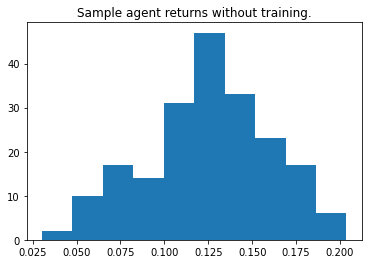

In [11]:
SAMPLES = 200
STOCKS = 20

def calculate_agent_stats(Env,data,agent,stocks,samples):
    sar = sampled_agent_reward(Env,data,[agent],stocks,samples)
    
    m = np.mean(sar[agent.name])
    s = np.std(sar[agent.name])
    L = m - 1.96 * (s / np.sqrt(SAMPLES)) 
    H = m + 1.96 * (s / np.sqrt(SAMPLES)) 

    print(f"Mean return: {m:.4f}.")
    print(f"Standard deviation: {s:.4f}.")
    print(f"95% confidence interval: [{L:.4f},{H:.4f}].")

    return sar

sar = calculate_agent_stats(TradingEnv,validation_data,agent,STOCKS,SAMPLES)
plt.hist(sar[agent.name])
plt.title("Sample agent returns without training.")
plt.show()



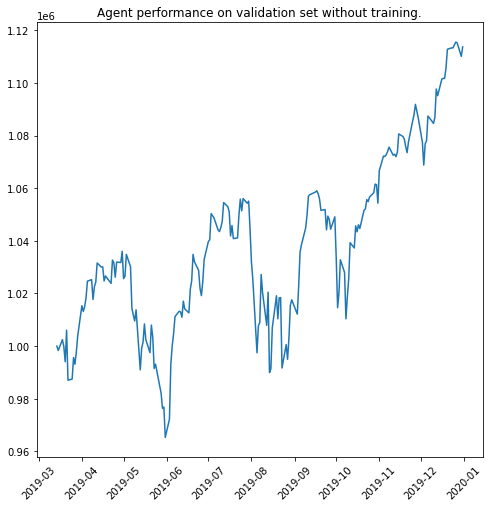

Initial value of portfolio:  1000000.0
Final value of portfolio:  1113669.9
Maximum value of portfolio:  1115522.9
Minimum value of portfolio:  965287.7


In [12]:
# Simulate untrained agent to view baseline
loss = agent_loss(validation_env,agent)
plt.figure(figsize=(8,8))
plt.plot(validation_dates[start_idx:], validation_env.portfolio_value_hist)
plt.xticks(rotation=45)
plt.title('Agent performance on validation set without training.')
plt.show()
portfolio_vals = validation_env.portfolio_value_hist
print('Initial value of portfolio: ',portfolio_vals[0].numpy())
print('Final value of portfolio: ', portfolio_vals[-1].numpy())
print('Maximum value of portfolio: ',max(portfolio_vals).numpy())
print('Minimum value of portfolio: ',min(portfolio_vals).numpy())

## Agent training

In [13]:
TRADING_DAYS_PER_YEAR = 253

#@tf.function
def train_step(agent,batch):
    """Runs a model training step."""
    env = TradingEnv(batch,train_noise=0.1)
 
    with tf.GradientTape() as tape:
        tape.watch(agent.model.trainable_variables)
        loss = agent_loss(env,agent,dsct = 0.99)

        grad = tape.gradient(loss,agent.model.trainable_variables)
        grad = [g / tf.reduce_mean(tf.abs(g)) for g in grad]
        agent.opt.apply_gradients(zip(grad,agent.model.trainable_variables))

    reward = -TRADING_DAYS_PER_YEAR * loss/(env._end_tick-env._start_tick)

    return reward


In [14]:
def Callback_EarlyStopping(RewardsList, min_delta=0, patience=30):
    
    if RewardsList[-1] != RewardsList[-1]:
        print('NAN error')
        return True   


    #No early stopping for 3*patience epochs 
    if len(RewardsList)//patience < 3 :
        return False
    #Mean loss for last patience epochs and second-last patience epochs
    mean_previous = np.mean(RewardsList[::-1][2*patience:3*patience]) #third-last
    mean_recent = np.mean(RewardsList[::-1][:patience]) #last
    #you can use relative or absolute change
    delta = mean_recent - mean_previous # change
    percent_delta = delta / mean_previous  # relative change
    if percent_delta < min_delta : 
        print(f"*CB_ES* Percent change in reward value: {percent_delta*1e2:.4f}")
        return True 
    else:
        return False

In [15]:
train_avg_rewards = []
val_avg_rewards = []
MAX_EPOCHS = 250
n_substocks = 20
VALIDATION_SAMPLES = 50
for epoch in range(MAX_EPOCHS):
    training_rewards = []
    for batch in batched_training_data:
        subsample = random.sample(list(range(n_stocks)),n_substocks)
        sub_batch = batch[subsample,:,:]

        reward = train_step(agent,sub_batch)
        
        training_rewards.append(reward)
    
    train_avg_rewards.append(np.mean(training_rewards))

    sar = sampled_agent_reward(TradingEnv,validation_data,[agent],n_substocks,VALIDATION_SAMPLES)
    val_avg_rewards.append(np.mean(sar[agent.name]))
    


    if Callback_EarlyStopping(val_avg_rewards):
        break


In the above code, note that a random subset of stocks are selected each epoch for training and validation. The purpose for this is to temper the possibility of overfitting to a single overperforming or underperforming stock. However, as a result the output performance over epochs is noisy. 

Due to the noise we will plot a rolling average of the training and validation rewards.

In [ ]:
df = pd.DataFrame({'training rewards':train_avg_rewards,'validation rewards':val_avg_rewards})

sns.lineplot( data = df.rolling(10, min_periods=1).mean())
plt.legend(loc='upper right',bbox_to_anchor=(1.5, 1) )
plt.title("Training and validation returns per epoch")
plt.show()

In [ ]:
sar = calculate_agent_stats(TradingEnv,validation_data,agent,STOCKS,SAMPLES)
plt.hist(sar[agent.name])
plt.title("Sample agent returns after training.")
plt.show()

In [ ]:
# Simulate trained agent to view behavior after training
loss = agent_loss(validation_env,agent)
plt.figure(figsize=(8,8))
plt.plot(validation_dates[start_idx:], validation_env.portfolio_value_hist)
plt.xticks(rotation=45)
plt.title(f'Agent performance on validation set after {epoch} training epochs.')
plt.show()
print('Initial value of portfolio: ',validation_env.portfolio_value_hist[0].numpy())
print('Final value of portfolio: ',validation_env.portfolio_value_hist[-1].numpy())
print('Maximum value of portfolio: ',max(validation_env.portfolio_value_hist).numpy())
print('Minimum value of portfolio: ',min(validation_env.portfolio_value_hist).numpy())

In [ ]:
with open('dpm_agent.dill','wb') as dill_file:
    dill.dump(agent, dill_file)

In [ ]:
agent.model.summary()